# Beginners Guide to Text Generation using LSTMs

Text Generation is a type of Language Modelling problem. Language Modelling is the core problem for a number of of natural language processing tasks such as speech to text, conversational system, and text summarization. A trained language model learns the likelihood of occurrence of a word based on the previous sequence of words used in the text. Language models can be operated at character level, n-gram level, sentence level or even paragraph level. In this notebook, I will explain how to create a language model for generating natural language text by implement and training state-of-the-art Recurrent Neural Network. 

### Generating News headlines 

In this kernel, I will be using the dataset of [New York Times Comments and Headlines](https://www.kaggle.com/aashita/nyt-comments) to train a text generation language model which can be used to generate News Headlines


## 1. Import the libraries

As the first step, we need to import the required libraries:

In [1]:
# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 
#from keras import Input

import tensorflow as tf

# set seeds for reproducability
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(2)
seed(1)

import pandas as pd
import numpy as np
import string, os 

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.


## 2. Load and explore the dataset

Load the dataset of news headlines.
Make a list of all the article headlines, except where the headline is 'Unknown'. Each entry in the list is a headline. We are not using the rest of the fields in the data set (i.e Author, type, date, section, ...)

In [2]:
curr_dir = '../input/'
all_headlines = []
for filename in os.listdir(curr_dir):
    if 'Articles' in filename:
        article_df = pd.read_csv(curr_dir + filename)
        all_headlines.extend(list(article_df.headline.values))
        break

all_headlines = [h for h in all_headlines if h != "Unknown"]

Let's look at the data

In [3]:
print(f'There are {len(all_headlines)} headlines in the list')
print('Let\'s look at the first few headlines:')
all_headlines[0:10]

There are 829 headlines in the list
Let's look at the first few headlines:


['N.F.L. vs. Politics Has Been Battle All Season Long',
 'Voice. Vice. Veracity.',
 'A Stand-Up’s Downward Slide',
 'New York Today: A Groundhog Has Her Day',
 'A Swimmer’s Communion With the Ocean',
 'Trail Activity',
 'Super Bowl',
 'Trump’s Mexican Shakedown',
 'Pence’s Presidential Pet',
 'Fruit of a Poison Tree']

Some statistics

In [4]:
nw=[]
for i in all_headlines:
    nw.append(len(i.split()))
    
print(f'Shortest article has {min(nw)} words')
print(f'Longest article has {max(nw)} words')
print(f'Average words per article {int(sum(nw)/len(nw))}')

Shortest article has 1 words
Longest article has 18 words
Average words per article 6


## 3. Dataset preparation

### 3.1 Dataset cleaning 

In dataset preparation step, we will first perform text cleaning of the data which includes removal of punctuations and lower casing all the words. 

In [5]:
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt 

corpus = [clean_text(x) for x in all_headlines]
corpus[:10]

['nfl vs politics has been battle all season long',
 'voice vice veracity',
 'a standups downward slide',
 'new york today a groundhog has her day',
 'a swimmers communion with the ocean',
 'trail activity',
 'super bowl',
 'trumps mexican shakedown',
 'pences presidential pet',
 'fruit of a poison tree']

### 3.2 Generating Sequence of N-gram Tokens

Language modelling requires a sequence input data, as given a sequence (of words/tokens) the aim is the predict next word/token.  

The next step is Tokenization. Tokenization is a process of extracting tokens (terms / words) from a corpus. Python’s library Keras has inbuilt model for tokenization which can be used to obtain the tokens and their index in the corpus. After this step, every text document in the dataset is converted into sequence of tokens. 


In [6]:
# Instantiate the Tokenizer class
tokenizer = Tokenizer()

## tokenization
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

## convert data to sequence of tokens 
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

print(total_words)
input_sequences[:10]

2288


[[660, 117],
 [660, 117, 72],
 [660, 117, 72, 73],
 [660, 117, 72, 73, 661],
 [660, 117, 72, 73, 661, 662],
 [660, 117, 72, 73, 661, 662, 63],
 [660, 117, 72, 73, 661, 662, 63, 29],
 [660, 117, 72, 73, 661, 662, 63, 29, 210],
 [211, 663],
 [211, 663, 664]]

In the above output [30, 507], [30, 507, 11], [30, 507, 11, 1] and so on represents the ngram phrases generated from the input data. where every integer corresponds to the index of a particular word in the complete vocabulary of words present in the text. For example

**Headline:** i stand  with the shedevils  
**Ngrams:** | **Sequence of Tokens**

<table>
<tr><td>Ngram </td><td> Sequence of Tokens</td></tr>
<tr> <td>i stand </td><td> [30, 507] </td></tr>
<tr> <td>i stand with </td><td> [30, 507, 11] </td></tr>
<tr> <td>i stand with the </td><td> [30, 507, 11, 1] </td></tr>
<tr> <td>i stand with the shedevils </td><td> [30, 507, 11, 1, 975] </td></tr>
</table>



### 3.3 Padding the Sequences and obtain Variables : Predictors and Target

Now that we have generated a data-set which contains sequence of tokens, it is possible that different sequences have different lengths. Before starting training the model, we need to pad the sequences and make their lengths equal. We can use pad_sequence function of Kears for this purpose. To input this data into a learning model, we need to create predictors and label. We will create N-grams sequence as predictors and the next word of the N-gram as label. For example:


Headline:  they are learning data science

<table>
<tr><td>PREDICTORS </td> <td>           LABEL </td></tr>
<tr><td>they                   </td> <td>  are</td></tr>
<tr><td>they are               </td> <td>  learning</td></tr>
<tr><td>they are learning      </td> <td>  data</td></tr>
<tr><td>they are learning data </td> <td>  science</td></tr>
</table>

In [7]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))  
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

In [8]:
print(predictors[0:10])

print(len(label[0]))
print(label[0])
print(label[0][115:120])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 660]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 660 117]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 660 117  72]
 [  0   0   0   0   0   0   0   0   0   0   0   0 660 117  72  73]
 [  0   0   0   0   0   0   0   0   0   0   0 660 117  72  73 661]
 [  0   0   0   0   0   0   0   0   0   0 660 117  72  73 661 662]
 [  0   0   0   0   0   0   0   0   0 660 117  72  73 661 662  63]
 [  0   0   0   0   0   0   0   0 660 117  72  73 661 662  63  29]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 211]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 211 663]]
2288
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. 0. 0.]


Perfect, now we can obtain the input vector X and the label vector Y which can be used for the training purposes. Recent experiments have shown that recurrent neural networks have shown a good performance in sequence to sequence learning and text data applications. Lets look at them in brief.

## 4. LSTMs for Text Generation

![](http://www.shivambansal.com/blog/text-lstm/2.png)

Unlike Feed-forward neural networks in which activation outputs are propagated only in one direction, the activation outputs from neurons propagate in both directions (from inputs to outputs and from outputs to inputs) in Recurrent Neural Networks. This creates loops in the neural network architecture which acts as a ‘memory state’ of the neurons. This state allows the neurons an ability to remember what have been learned so far.

The memory state in RNNs gives an advantage over traditional neural networks but a problem called Vanishing Gradient is associated with them. In this problem, while learning with a large number of layers, it becomes really hard for the network to learn and tune the parameters of the earlier layers. To address this problem, A new type of RNNs called LSTMs (Long Short Term Memory) Models have been developed.

LSTMs have an additional state called ‘cell state’ through which the network makes adjustments in the information flow. The advantage of this state is that the model can remember or forget the leanings more selectively. To learn more about LSTMs, here is a great post. Lets architecture a LSTM model in our code. I have added total three layers in the model.

1. Input Layer : Takes the sequence of words as input
2. LSTM Layer : Computes the output using LSTM units. I have added 100 units in the layer, but this number can be fine tuned later.
3. Dropout Layer : A regularisation layer which randomly turns-off the activations of some neurons in the LSTM layer. It helps in preventing over fitting. (Optional Layer)
4. Output Layer : Computes the probability of the best possible next word as output

We will run this model for total 100 epoochs but it can be experimented further.

In [9]:
print(max_sequence_len)
print(total_words)

17
2288


In [10]:
embedding_dim = 10
input_len = max_sequence_len - 1

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=total_words, output_dim=embedding_dim, input_length=input_len),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(total_words, activation='softmax')
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 10)            22880     
_________________________________________________________________
lstm (LSTM)                  (None, 100)               44400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 2288)              231088    
Total params: 298,368
Trainable params: 298,368
Non-trainable params: 0
_________________________________________________________________


Compile the model

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Lets train our model now

In [12]:
epochs = 500
batch_size = 128

history = model.fit(predictors, 
                    label, 
                    epochs=epochs, 
                    batch_size=batch_size)

Epoch 1/500
4544/4544 [==============================] - 4s 802us/step - loss: 7.5489 - acc: 0.0330
Epoch 2/500
4544/4544 [==============================] - 1s 199us/step - loss: 6.9259 - acc: 0.0370
Epoch 3/500
4544/4544 [==============================] - 1s 197us/step - loss: 6.8081 - acc: 0.0392
Epoch 4/500
4544/4544 [==============================] - 1s 203us/step - loss: 6.7746 - acc: 0.0392
Epoch 5/500
4544/4544 [==============================] - 1s 196us/step - loss: 6.7461 - acc: 0.0392
Epoch 6/500
4544/4544 [==============================] - 1s 197us/step - loss: 6.7178 - acc: 0.0392
Epoch 7/500
4544/4544 [==============================] - 1s 199us/step - loss: 6.6860 - acc: 0.0392
Epoch 8/500
4544/4544 [==============================] - 1s 198us/step - loss: 6.6486 - acc: 0.0392
Epoch 9/500
4544/4544 [==============================] - 1s 197us/step - loss: 6.6144 - acc: 0.0337
Epoch 10/500
4544/4544 [==============================] - 1s 206us/step - loss: 6.5808 - acc: 0.0392

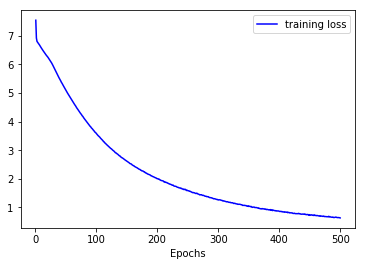

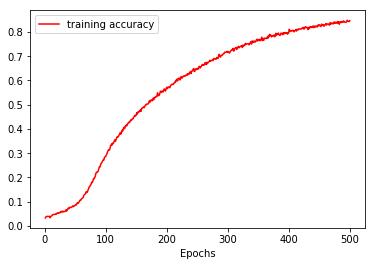

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
train_accy = history_dict['acc']
epochs = range(1, len(train_accy)+1)
plt.plot(epochs, train_loss, 'b', label='training loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()
plt.plot(epochs, train_accy, 'r', label='training accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## 5. Generating the text 

Great, our model architecture is now ready and we can train it using our data. Next lets write the function to predict the next word based on the input words (or seed text). We will first tokenize the seed text, pad the sequences and pass into the trained model to get predicted word. The multiple predicted words can be appended together to get predicted sequence.


In [14]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

## 6. Let's generate some text

Use a seed string and generate the next 'nw' words

In [15]:
nw = 5
print (generate_text("united states", nw, model, max_sequence_len))
print (generate_text("the president did", nw, model, max_sequence_len))
print (generate_text("inflation is moving", nw, model, max_sequence_len))
print (generate_text("india and china", nw, model,max_sequence_len))
print (generate_text("new york", nw, model, max_sequence_len))
print (generate_text("science and technology", nw, model, max_sequence_len))

United States The Man Who Now On
The President Did Trumps Forecasts Of The Them
Inflation Is Moving Youre No Colin Firth A
India And China And Got Its Sound Violins
New York Today A Plethora Of Pancakes
Science And Technology Staff Rethink Tactics After Stumbles
